In [264]:
%matplotlib inline
from pysgpp import RegressionLearner, RegularGridConfiguration, AdpativityConfiguration, SLESolverConfiguration, \
RegularizationConfiguration, DataMatrix, DataVector

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import to_data_matrix, get_xy, split

import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [252]:
def generateData(dim, level, noiseStd, num):
    np.random.seed(42)
    grid_config = RegularGridConfiguration()
    grid_config.dim_ = dim
    grid_config.level_ = level
    grid_config.type_ = 6
    grid_config.t_ = 0.0

    adaptivity_config = AdpativityConfiguration()
    adaptivity_config.numRefinements = 0

    solver_config = SLESolverConfiguration()
    solver_config.type_ = 0
    solver_config.maxIterations_ = 50
    solver_config.threshold_ = 1e-5

    regularization_config = RegularizationConfiguration()
    regularization_config.type_ = 2
    regularization_config.exponentBase_ = 0.25
    regularization_config.lambda_ = 0.1

    estimator = RegressionLearner(grid_config, adaptivity_config, solver_config, solver_config, regularization_config)
    
    estimator.initializeWeights()
    X = to_data_matrix(np.random.random((num, dim)))
    y = np.matrix(estimator.predict(X).array()).T 
    if noiseStd != 0.0:
        y = y + np.matrix(np.random.normal(0,noiseStd, num)).T
    X = X.array()
    df = pd.DataFrame(np.append(X,y,axis=1)).reset_index(drop=False)
    df.columns = ['index'] + ['x' + str(x) for x in range(0,dim)] + ['y']
    return df

def saveData(dim, level, noiseStd, num, filename):
    df = generateData(dim, level, noiseStd, num)
    prefix = '../datasets/processed/diagonal_test/'
    df.drop(['index'], axis=1).to_csv(os.path.join(prefix, filename), index=None)

,index,x0,x1,y
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,0.494333,0.500694,-0.628974
std,577.494589,0.293217,0.287527,50.349699
min,0.000000,0.000012,0.001474,-158.451560
25%,499.750000,0.232164,0.254778,-35.317668
50%,999.500000,0.498312,0.502042,0.382668
75%,1499.250000,0.750999,0.748120,33.225349
max,1999.000000,0.999414,0.999718,162.171454


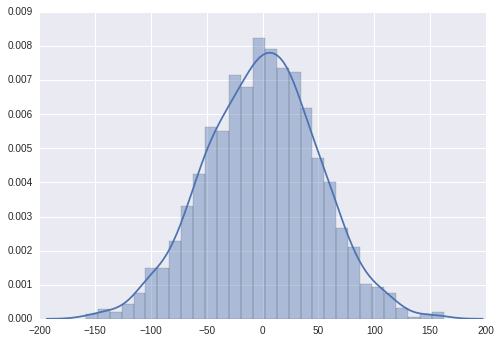

In [259]:
df = generateData(2, 5, 50.0, 2000)
_, y = get_xy(df)
sns.distplot(y)
df.describe()

In [276]:
saveData(2,5,1.0, 2000, 'diag_test_1_noise.csv')
saveData(2,5,10.0, 2000, 'diag_test_10_noise.csv')
saveData(2,5,50.0, 2000, 'diag_test_50_noise.csv')

In [174]:
y

matrix([[-0.60989349],
        [ 0.61869781],
        [ 0.31738124],
        ..., 
        [ 0.34118568],
        [ 0.05849453],
        [ 0.50166105]])

In [179]:
np.append(X,y, axis=1).shape

(2000, 5)

In [189]:
X.shape, y.shape

((2000, 5), (2000,))

In [261]:
dfr = pd.read_csv("../datasets/processed/diagonal_test/diag_test_50_noise.csv")

In [274]:
X, y = get_xy(dfr)
y.var()

2533.8246356161972

In [267]:
X

array([[ 0.37454012,  0.95071431],
       [ 0.73199394,  0.59865848],
       [ 0.15601864,  0.15599452],
       ..., 
       [ 0.49253538,  0.44210703],
       [ 0.33440118,  0.39457232],
       [ 0.52994059,  0.16136736]])

In [272]:
dfr.describe()

,x0,x1,y
count,2000.000000,2000.000000,2000.000000
mean,0.494333,0.500694,-0.628974
std,0.293217,0.287527,50.349699
min,0.000012,0.001474,-158.451560
25%,0.232164,0.254778,-35.317668
50%,0.498312,0.502042,0.382668
75%,0.750999,0.748120,33.225349
max,0.999414,0.999718,162.171454


In [273]:
df.describe()

,index,x0,x1,y
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,0.494333,0.500694,-0.628974
std,577.494589,0.293217,0.287527,50.349699
min,0.000000,0.000012,0.001474,-158.451560
25%,499.750000,0.232164,0.254778,-35.317668
50%,999.500000,0.498312,0.502042,0.382668
75%,1499.250000,0.750999,0.748120,33.225349
max,1999.000000,0.999414,0.999718,162.171454


In [312]:
(np.matrix(np.zeros((1,2000))) + np.matrix(np.random.normal(0,1.0, 2000))).std()

0.98042198835804661

In [336]:
r = np.matrix(np.random.normal(0,10.0, 2000))

54.364370223956733